##문자를 읽을 수 있는 딥러닝

개발 환경
<br/>데이터 정보
<br/>OCR 서비스 구상
<br/>Keras OCR
<br/>Tesseract

OCR 서비스 구현
<br/>서비스 작동 원리

사용자 시뮬레이션
<br/>파일 초기화
<br/>데이터프레임 초기화
<br/>도서 사진 파일 업로드
<br/>OCR. 웹 크롤링
<br/>클립보드로 메모장에 저장

결론
<br/>참고문헌

# 개발 환경

In [ ]:
!pip install keras-ocr

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

In [ ]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

In [ ]:
pip install --ignore-installed Pillow==9.0.0

pytesseract.image_to_string 사용 시에
<br/>AttributeError: module 'PIL.Image' has no attribute 'Resampling'가 발생하므로
<br/>Pillow==9.0.0 버전을 설치하고
<br/>Restart Runtime한다.

In [ ]:
import sys
import os
import cv2
import keras_ocr
import pytesseract
from pytesseract import image_to_string
from PIL import Image
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [ ]:
from google.colab import files

In [ ]:
from selenium import webdriver
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
from urllib.parse import quote_plus
from selenium.webdriver.common.keys import Keys
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip freeze > '/content/drive/MyDrive/lms/library_version.txt'

In [ ]:
library_name = ['keras-ocr=', 'pytesseract=', 'pandas=', 'matplotlib=', 'opencv-python',
                 'selenium=', 'webdriver', 'urllib', 'bs4', 'clipboard', 'image', 'Pillow']
library_version = []
f = open('/content/drive/MyDrive/lms/library_version.txt', 'r')
line = f.readline()
while True:
    line = f.readline()
    if not line:
      break
    for i in library_name:
      if i in line:
        library_version.append(line)

f.close()

print(sys.version)
print()
print(str(library_version).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='')

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

bs4==0.0.1 clipboard==0.0.4 imageio==2.4.1 imagesize==1.3.0 keras-ocr==0.9.1 matplotlib==3.2.2 opencv-python==4.1.2.30 pandas==1.3.5 Pillow==9.1.1 pytesseract==0.3.9 scikit-image==0.18.3 selenium==4.2.0 sklearn-pandas==1.8.0 urllib3==1.26.9

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Google Colab에서 할당된 GPU를 확인한다.
<br/>고용량 메모리 VM에 액세스한다.

#데이터 정보


영어 원서 표지 사진 3장이다.

이렇게 데이터를 선정한 이유는
<br/>Keras OCR, Tesseract는 영어에서 성능이 뛰어난 편이며
<br/>한국어에서는 제대로 인식하지 못하기 때문이다.

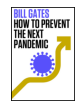

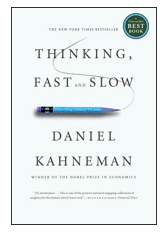

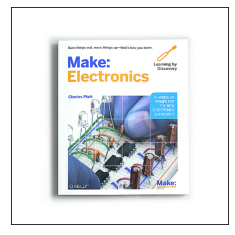

In [ ]:
image_path = [
  '/content/drive/MyDrive/lms/ocr/book1.jpg',
  '/content/drive/MyDrive/lms/ocr/book2.jpg',
  '/content/drive/MyDrive/lms/ocr/book3.jpg'
]

rows = 5
cols = 2
fig = plt.figure(figsize=(20,10))
for idx, path in enumerate(image_path, 1):
    ax = fig.add_subplot(rows, cols, idx)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

#OCR 서비스 구상

**OCR 도서 정보 검색 서비스**

사진 속의 책 제목을 인식하여 인터넷 도서 정보를 검색한다.

스마트폰 카메라로 촬영을 하면 인식한 책 제목에 대한 도서 정보를 웹 크롤링하여 클립보드로 복사하는 기능이 있다.
<br/>도서관, 서점, 북카페, 책방에서 마음에 드는 책의 정보를 메모하고 싶을 때 유용하다.

1) OCR로 이미지 속의 책 제목 텍스트를 추출한다.
<br/>2) 책 제목을 [네이버 책 사이트](https://book.naver.com/search/search.naver?sm=sta_hty.book&sug=&where=nexearch&query=)에서 검색을 한다.
<br/>3) CSS Selector를 이용하여 도서 정보를 수집한다.
<br/>4) 클립보드 형식으로 도서 정보를 복사한다.

#Keras OCR

In [ ]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


만들어둔 파이프라인의 recognize() 에 이미지를 넣는다.

In [ ]:
images = [ keras_ocr.tools.read(path) for path in image_path]
prediction_groups = [pipeline.recognize([path]) for path in image_path]

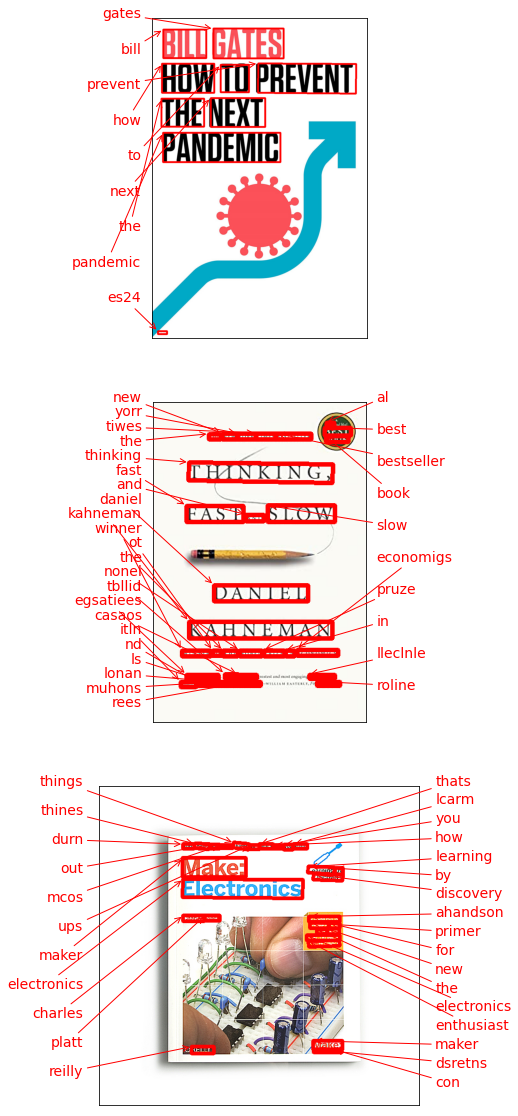

In [ ]:
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

#Tesseract

In [ ]:
image = cv2.imread(image_path[0])
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
rgb_image = np.asarray(rgb_image)
text1 = pytesseract.image_to_string(rgb_image, lang='eng')
text1 = re.sub(r"\s+", " ", text1)
print(text1)

BILL GATES HOW TO PREVENT THE NEXT PANDEMIC = 


In [ ]:
image = cv2.imread(image_path[1])
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
text2 = pytesseract.image_to_string(rgb_image, lang='eng')
text2 = re.sub(r"\s+", " ", text2)
print(text2)

THINKING, FAST SLOW We DANIEL KAHNEMAN 


In [ ]:
image = cv2.imread(image_path[2])
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
text3 = pytesseract.image_to_string(rgb_image, lang='eng')
text3 = re.sub(r"\s+", " ", text3)
print(text3)

 Make: Sin Electronics 


#OCR 서비스 구현

##서비스 작동 원리

In [ ]:
uploaded = files.upload() 

for fn in uploaded.keys(): 
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving book1.jpg to book1.jpg
User uploaded file "book1.jpg" with length 95751 bytes


In [ ]:
ls -al

total 116
drwxr-xr-x 1 root root  4096 Jun 12 20:22 ./
drwxr-xr-x 1 root root  4096 Jun 12 19:13 ../
-rw-r--r-- 1 root root 95751 Jun 12 20:22 book1.jpg
drwxr-xr-x 4 root root  4096 Jun  1 13:49 .config/
drwx------ 5 root root  4096 Jun 12 19:17 drive/
drwxr-xr-x 1 root root  4096 Jun  1 13:50 sample_data/


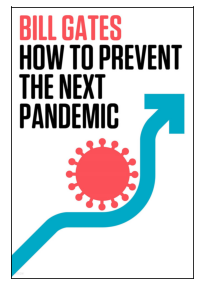

In [ ]:
c = imread('book1.jpg')
plt.figure(figsize=(5,5))
plt.xticks([])
plt.yticks([])
plt.imshow(c)
plt.show()

In [ ]:
image = cv2.imread('book1.jpg')
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
rgb_image = np.asarray(rgb_image)
text1 = pytesseract.image_to_string(rgb_image, lang='eng')
text1 = re.sub(r"\s+", " ", text1)
print(text1)

BILL GATES HOW TO PREVENT THE NEXT PANDEMIC = 


In [ ]:
options = webdriver.ChromeOptions()
options.add_argument('--headless')       
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver', options=options)

In [ ]:
url = 'https://book.naver.com/search/search.naver?sm=sta_hty.book&sug=&where=nexearch&query='
kword = text1
base_url = url + quote_plus(kword)
base_url

'https://book.naver.com/search/search.naver?sm=sta_hty.book&sug=&where=nexearch&query=BILL+GATES+HOW+TO+PREVENT+THE+NEXT+PANDEMIC+%3D+'

In [ ]:
driver.get(base_url)
book_info = driver.find_element_by_css_selector('#searchBiblioList > li:nth-child(1) > dl')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: find_element_by_css_selector is deprecated. Please use find_element(by=By.CSS_SELECTOR, value=css_selector) instead
  


In [ ]:
print(book_info.text)

How to Prevent the Next Pandemic (빌 게이츠 신간)
Gates, Bill 저 | KnopfPublishingGroup | 2022.05.03
0
| 네티즌리뷰 0건 |  33,500원 → 20,770원(-38%)
소개  HAPPENS NEXT. HOW CAN WE PREVENT A NEW PANDEMIC FROM KILLING MILLIONS OF PEOPLE AND DEVASTATING THE GLOBAL ECONOMY? CAN WE EVEN HOPE TO ACCOMPLISH THIS? BILL GATES BELIEVES THE ANSWER IS YES, AND IN THIS BOOK HE LAYS OUT CLEARLY AND CONVINCINGLY WHAT THE WORLD...


In [ ]:
first_book_info = book_info.text.split('\n')
first_book_info = pd.DataFrame(first_book_info).transpose()
first_book_info

,0,1,2,3,4
0,How to Prevent the Next Pandemic (빌 게이츠 신간),"Gates, Bill 저 | KnopfPublishingGroup | 2022.05.03",0,"| 네티즌리뷰 0건 | 33,500원 → 20,770원(-38%)",소개 HAPPENS NEXT. HOW CAN WE PREVENT A NEW PAN...


##사용자 시뮬레이션

###파일 초기화

In [ ]:
rm *.jpg

In [ ]:
ls

###데이터프레임 초기화

In [ ]:
first_book_info = pd.DataFrame(index=range(0, 1), columns = {'0'})

In [ ]:
first_book_info 

,0
0,NaN


###파일 업로드

In [ ]:
uploaded = files.upload() 

for fn in uploaded.keys(): 
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving book1.jpg to book1.jpg
Saving book2.jpg to book2.jpg
Saving book3.jpg to book3.jpg
User uploaded file "book1.jpg" with length 95751 bytes
User uploaded file "book2.jpg" with length 16342 bytes
User uploaded file "book3.jpg" with length 205174 bytes


In [ ]:
ls *.jpg  > directory.txt



###OCR. 웹 크롤링

In [ ]:
def OCR_Service(txt, first_book_info):


    f = open(txt, "r")
    lst = []
    while True:
      line = f.readline().strip()
      if not line: break
      lst.append(line)

    for jpg in lst:
      image = cv2.imread(jpg)
      rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      rgb_image = np.asarray(rgb_image)
      text = pytesseract.image_to_string(rgb_image, lang='eng')
      text = re.sub(r"\s+", " ", text)
    
      url = 'https://book.naver.com/search/search.naver?sm=sta_hty.book&sug=&where=nexearch&query='
      kword = text
      base_url = url + quote_plus(kword)
    
      driver.get(base_url)
    
      book_info = driver.find_element_by_css_selector('#searchBiblioList > li:nth-child(1) > dl')
    
      new_book_info = book_info.text.split('\n')
      new_book_info = pd.DataFrame(new_book_info).transpose()
      first_book_info =  first_book_info.append(new_book_info)
   
    return first_book_info.iloc[1:, :-1]

In [ ]:
book_info_memo = OCR_Service('directory.txt', first_book_info)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: find_element_by_css_selector is deprecated. Please use find_element(by=By.CSS_SELECTOR, value=css_selector) instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: find_element_by_css_selector is deprecated. Please use find_element(by=By.CSS_SELECTOR, value=css_selector) instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: find_element_by_css_selector is deprecated. Please use find_element(by=By.CSS_SELECTOR, value=css_selector) instead


In [ ]:
book_info_memo 

,0,1,2,3,4,5
0,How to Prevent the Next Pandemic (빌 게이츠 신간),"Gates, Bill 저 | KnopfPublishingGroup | 2022.05.03",0,"| 네티즌리뷰 0건 | 33,500원 → 20,770원(-38%)",소개 HAPPENS NEXT. HOW CAN WE PREVENT A NEW PAN...,NaN
0,"Thinking, Fast and Slow (Paperback) (생각에 관한 생각)",대니얼 카너먼(심리학자) 저 | Penguin | 2012.05.10,별점,10,"| 네티즌리뷰 6건 | 18,000원 → 14,940원(-17%)",소개 THE ANSWER LIES IN THE TWO WAYS WE MAKE CH...
0,"Encounters With Great Minds (빅 컨버세이션,영문판)",Hwang Chang-Gyu 저 | Timothy Atkinson 역 | 시공사 |...,0,"| 네티즌리뷰 0건 | 25,000원 → 22,500원(-10%)",소개 SAMSUNG ELECTRONICS AND KOREA TELECOM. THI...,NaN


###클립보드로 메모장에 저장

In [ ]:
book_info_memo.to_clipboard 

#결론

글씨체가 다른 텍스트, 영어가 아닌 다른 언어 텍스트를 인식하지 못한다.
<br/>성능이 뛰어난 Google Vision API 사용의 필요성을 느낀다.

도서 정보를 수집한 데이터프레임이 정돈되지 않았다.
<br/>pandas에 대한 공부의 필요성을 느낀다.

#참고문헌

**웹사이트**
<br/>[Module PIL has not attribute "Resampling"](https://stackoverflow.com/questions/71738218/module-pil-has-not-attribute-resampling)
<br/>[파이썬 Tesseract OCR 활용 (기본) - Python](https://yunwoong.tistory.com/58?category=902345)
<br/>[colab에서 selenium 사용하는 법](https://ai-run.tistory.com/47)
<br/>[셀레니움(selenium) 사용법: 설치부터 네이버 자동 로그인까지](https://itholic.github.io/python-selenium-tutorial/)